### **Decision Trees and Random Forest**

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
classification = pd.read_csv('https://raw.githubusercontent.com/morn12/tb/main/190%20(1).csv',parse_dates=['Date'])
classification.drop(['Date', 'Hour','SMP','Unnamed: 0'], axis=1, inplace=True)
classification
# האם הסמפי יהיה מעל 190 בהינתן פיצרים מסויימים
# האם ניתן לחזות מתי הסמפי יהיה מעל 190

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,24.47,0,1,0,0,0,0
1,24.30,0,1,0,0,0,0
2,24.17,0,1,0,0,0,0
3,23.99,0,1,0,0,0,0
4,23.93,0,1,0,0,0,0
...,...,...,...,...,...,...,...
30708,12.26,0,0,0,0,0,0
30709,12.27,0,0,0,0,0,0
30710,12.06,0,0,0,0,0,0
30711,12.06,0,0,0,0,0,0


#EDA

In [3]:
counts = classification.SMP_Above_190.value_counts()
percentage = [str(round(i/counts.sum()*100,2)) +'%' for i in counts]
percentage 

['89.83%', '10.17%']

In [4]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Low SMP', 'High SMP'],
    y=counts,
    marker_color=['LIGHTSKYBLUE','PLUM'],
    text=percentage,
    textposition='outside',
))
fig.update_layout(
    width=600,
    title='The SMP Level', 
    yaxis_title='Number of cases',
    )
fig.show()

## הפרדת המחלקות 

In [5]:
# Class count
count_class_0, count_class_1 = classification.SMP_Above_190.value_counts()

# Divide by class
df_class_0 = classification[classification['SMP_Above_190'] == 0]
df_class_1 = classification[classification['SMP_Above_190'] == 1]

## Up Sampling & Down Sampling

In [6]:
df_class_1_over = df_class_1.sample((count_class_1 * 3),replace=True) 
df_class_0_under = df_class_0.sample(count_class_1 * 3)

# ניפוח המחלקה הקטנה פי 3, ולאחר מכן לקיחת מחלקה רנדומלית מהמחלקה הגדולה שהיא בגודל
# המחלקה הקטנה החדשה

df_balanced = pd.concat([df_class_0_under, df_class_1_over], axis=0)
print('Random under-sampling:')
print(df_balanced.SMP_Above_190.value_counts())

Random under-sampling:
0    9375
1    9375
Name: SMP_Above_190, dtype: int64


In [7]:
df_balanced.reset_index(drop=True, inplace= True)

#מודל עצי החלטה

In [8]:
X = df_balanced.drop('SMP_Above_190',axis=1)
y = df_balanced['SMP_Above_190']
X

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,32.29,0,0,0,0,1
1,20.67,0,0,1,0,0
2,21.14,1,0,0,0,0
3,32.63,0,0,1,0,1
4,10.07,0,0,0,0,0
...,...,...,...,...,...,...
18745,24.54,1,0,0,0,0
18746,24.09,0,1,0,0,1
18747,27.66,1,0,0,0,0
18748,24.23,0,1,1,0,0


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [10]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

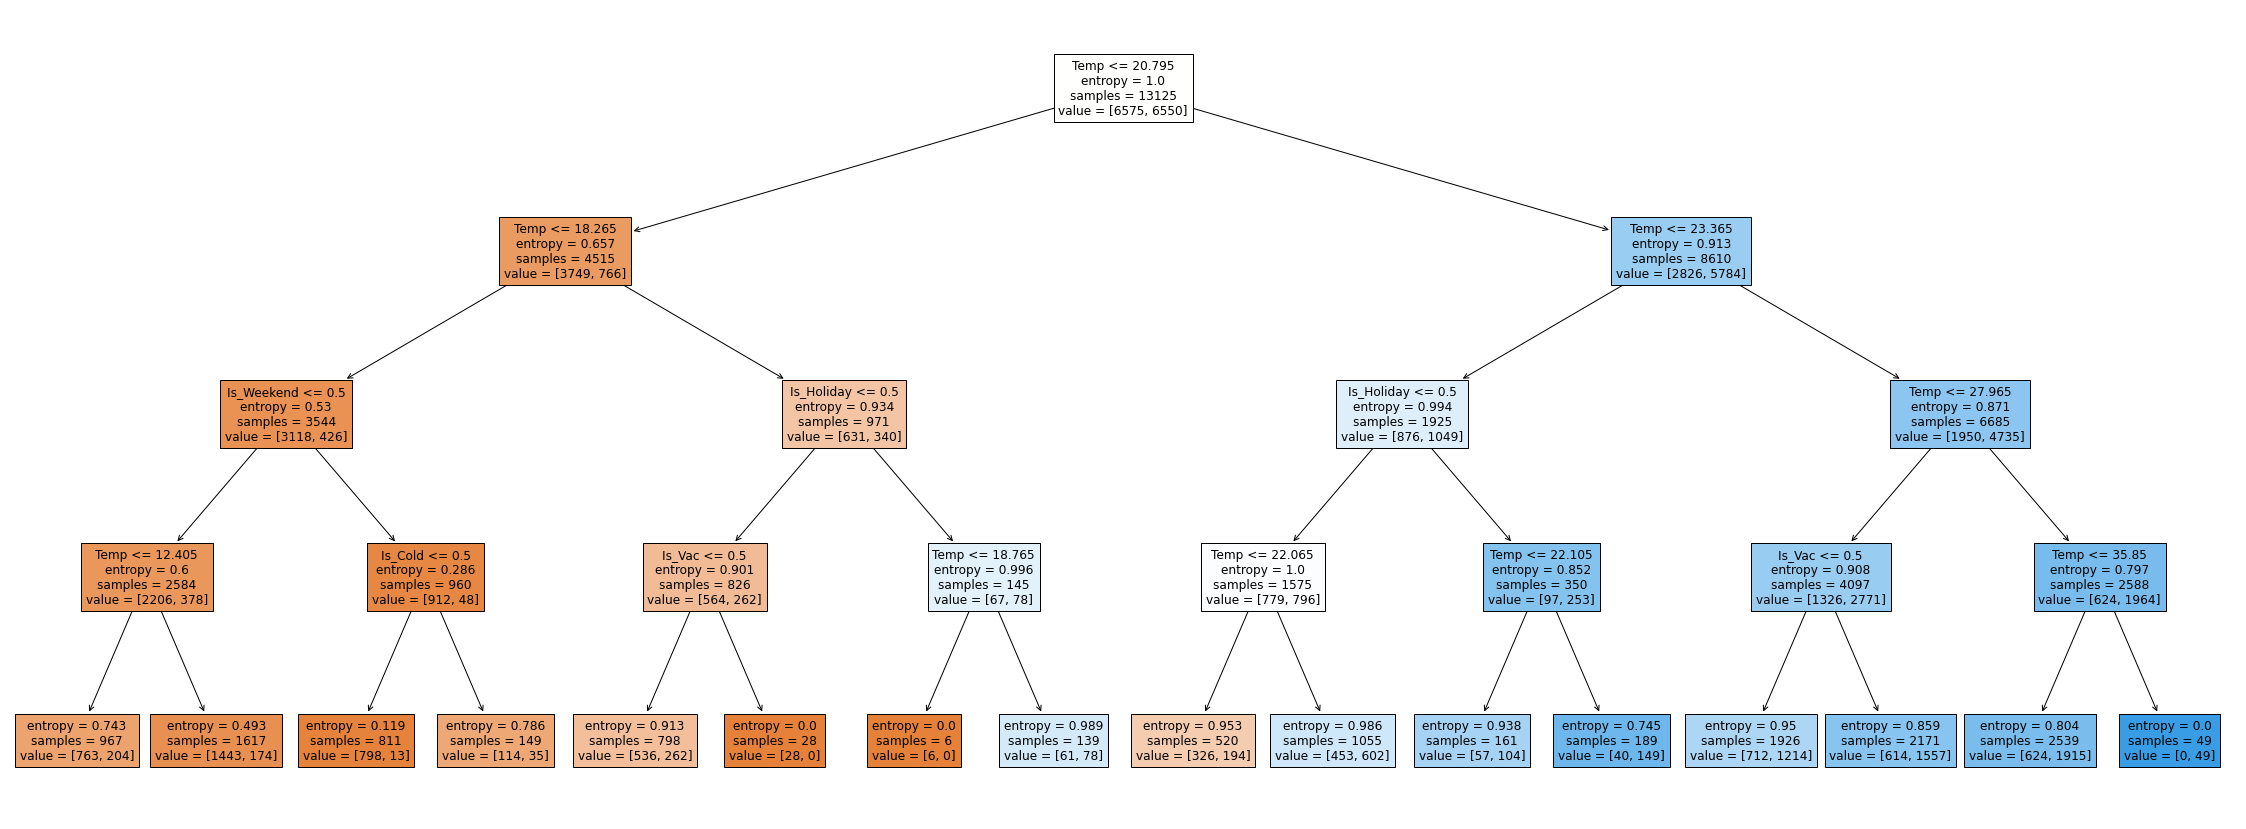

In [11]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show() # הצגת עץ החלטה גזום

In [12]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)
# בעזרת הגרף ניתן לראות שפיצר הטמפרטורה הוא המשפיע ביותר

##חיזוי והערכת המודל

In [13]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": df_balanced.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,0
15010,1,1
9630,1,1
16150,1,0
13141,1,1


In [14]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0

[[1719 1081]
 [ 403 2422]]
              precision    recall  f1-score   support

           0       0.81      0.61      0.70      2800
           1       0.69      0.86      0.77      2825

    accuracy                           0.74      5625
   macro avg       0.75      0.74      0.73      5625
weighted avg       0.75      0.74      0.73      5625



# מודל יערות רנדומיים

In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') 

In [16]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [17]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))

# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0

[[2090  710]
 [ 420 2405]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      2800
           1       0.77      0.85      0.81      2825

    accuracy                           0.80      5625
   macro avg       0.80      0.80      0.80      5625
weighted avg       0.80      0.80      0.80      5625



##Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.87733216, 0.87220476, 0.86089923, 0.87470446, 0.88328729,
       0.86366801, 0.86720594, 0.87347964, 0.86933244, 0.85518531])

In [19]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.81546667, 0.8208    , 0.81386667, 0.80853333, 0.82293333,
       0.8128    , 0.8112    , 0.81706667, 0.81066667, 0.79946667])

In [20]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())

Mean values
auc: 0.8697299256120677
accuracy:  0.8132800000000001


#מודל עצי החלטה ללא פיצר של גלי חום

In [21]:
without_HM = df_balanced.drop('Is_HW',axis=1)
without_HM

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,SMP_Above_190
0,32.29,0,0,0,0,0
1,20.67,0,0,1,0,0
2,21.14,1,0,0,0,0
3,32.63,0,0,1,0,0
4,10.07,0,0,0,0,0
...,...,...,...,...,...,...
18745,24.54,1,0,0,0,1
18746,24.09,0,1,0,0,1
18747,27.66,1,0,0,0,1
18748,24.23,0,1,1,0,1


In [22]:
X = without_HM.drop('SMP_Above_190',axis=1)
y = without_HM['SMP_Above_190']
X

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold
0,32.29,0,0,0,0
1,20.67,0,0,1,0
2,21.14,1,0,0,0
3,32.63,0,0,1,0
4,10.07,0,0,0,0
...,...,...,...,...,...
18745,24.54,1,0,0,0
18746,24.09,0,1,0,0
18747,27.66,1,0,0,0
18748,24.23,0,1,1,0


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [24]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

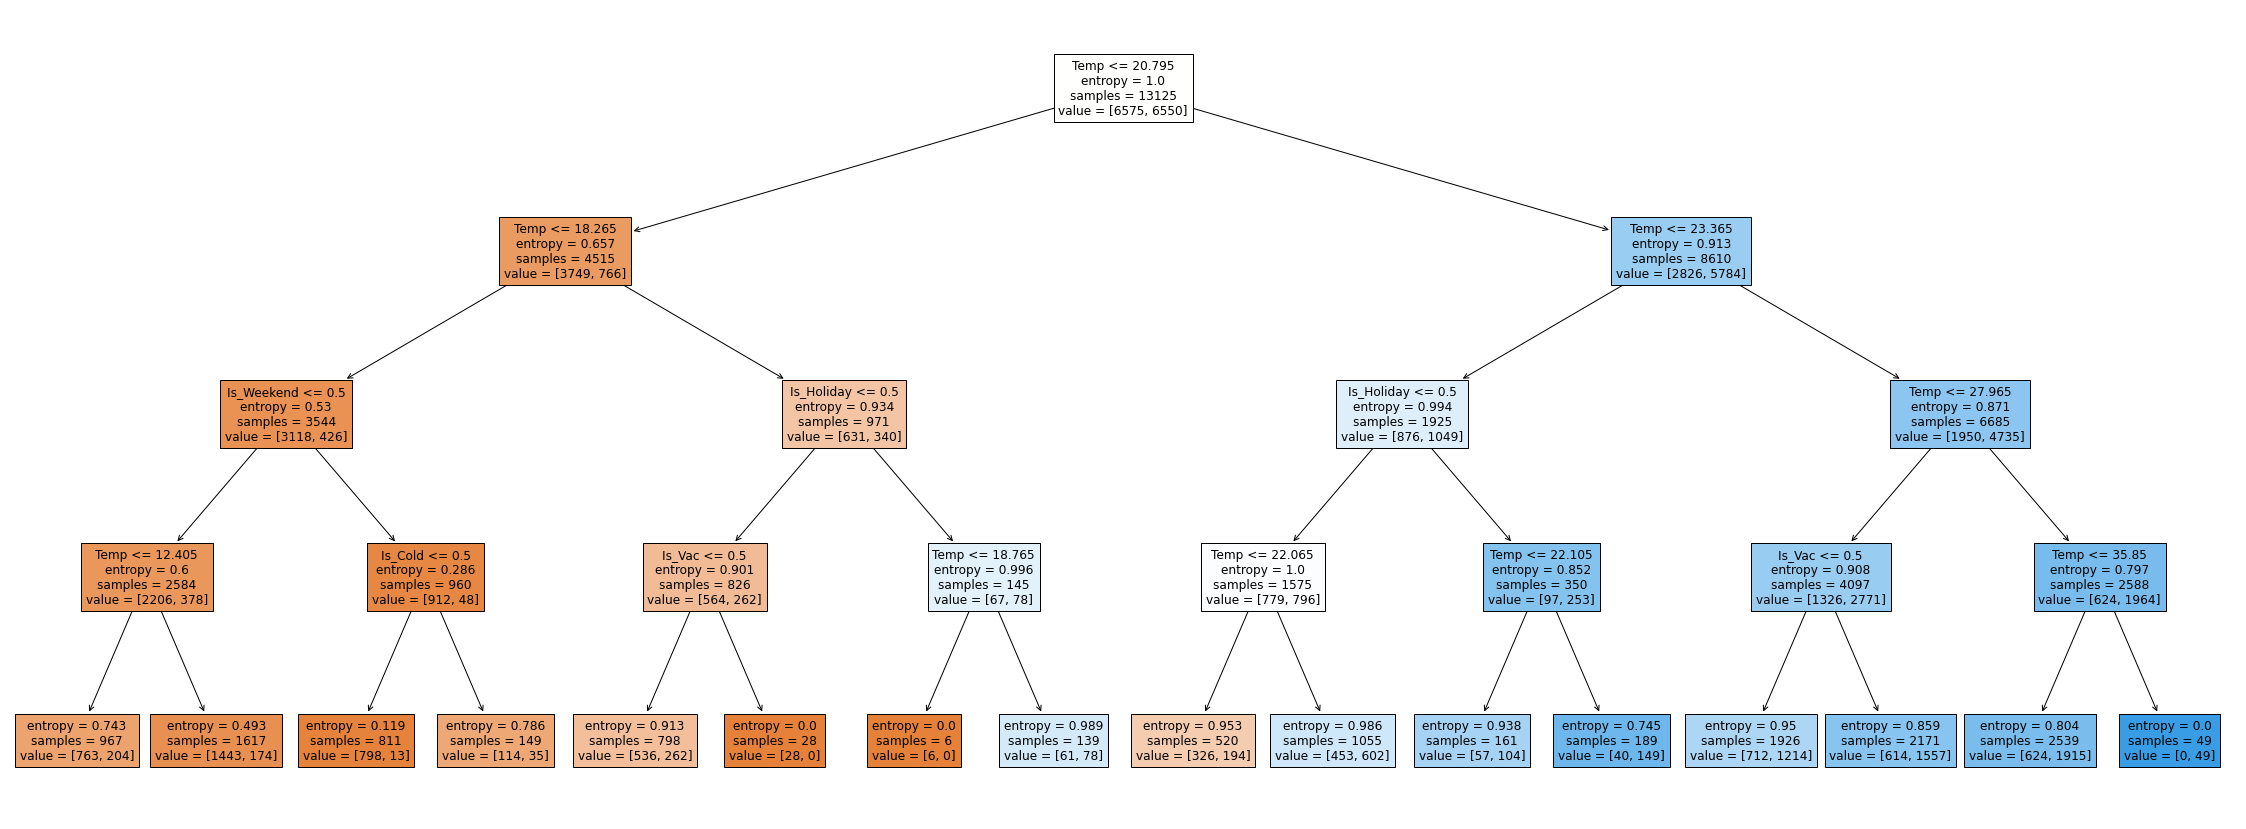

In [25]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show()

In [26]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)

###חיזוי והערכת המודל

In [27]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": without_HM.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,0
15010,1,1
9630,1,1
16150,1,0
13141,1,1


In [28]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# מודל חוזה טוב יותר 1

[[1719 1081]
 [ 403 2422]]
              precision    recall  f1-score   support

           0       0.81      0.61      0.70      2800
           1       0.69      0.86      0.77      2825

    accuracy                           0.74      5625
   macro avg       0.75      0.74      0.73      5625
weighted avg       0.75      0.74      0.73      5625



##יערות רנדומיים

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') # שלושים עצים

In [30]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [31]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))
# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0
# ניתן לראות שהמדדים עדיין גבוים, מה שמצביע שגלי חום אינם משפיעים משמעותית על המודל

[[2048  752]
 [ 444 2381]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2800
           1       0.76      0.84      0.80      2825

    accuracy                           0.79      5625
   macro avg       0.79      0.79      0.79      5625
weighted avg       0.79      0.79      0.79      5625



###Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.85979331, 0.86060967, 0.85521148, 0.86259054, 0.87329931,
       0.85374318, 0.86229699, 0.85938371, 0.8584752 , 0.84160138])

In [33]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.80693333, 0.81173333, 0.7936    , 0.80266667, 0.81973333,
       0.7936    , 0.80586667, 0.80426667, 0.7984    , 0.784     ])

In [34]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())

Mean values
auc: 0.8587004753636908
accuracy:  0.8020799999999999


#מודל עצי החלטה ללא פיצר של טמפרטורה

In [35]:
without_Temp = df_balanced.drop('Temp',axis=1)
without_Temp

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,0,0,0,0,1,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,1,0,1,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
18745,1,0,0,0,0,1
18746,0,1,0,0,1,1
18747,1,0,0,0,0,1
18748,0,1,1,0,0,1


In [36]:
X = without_Temp.drop('SMP_Above_190',axis=1)
y = without_Temp['SMP_Above_190']
X

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,0,0,0,0,1
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,1,0,1
4,0,0,0,0,0
...,...,...,...,...,...
18745,1,0,0,0,0
18746,0,1,0,0,1
18747,1,0,0,0,0
18748,0,1,1,0,0


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [38]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

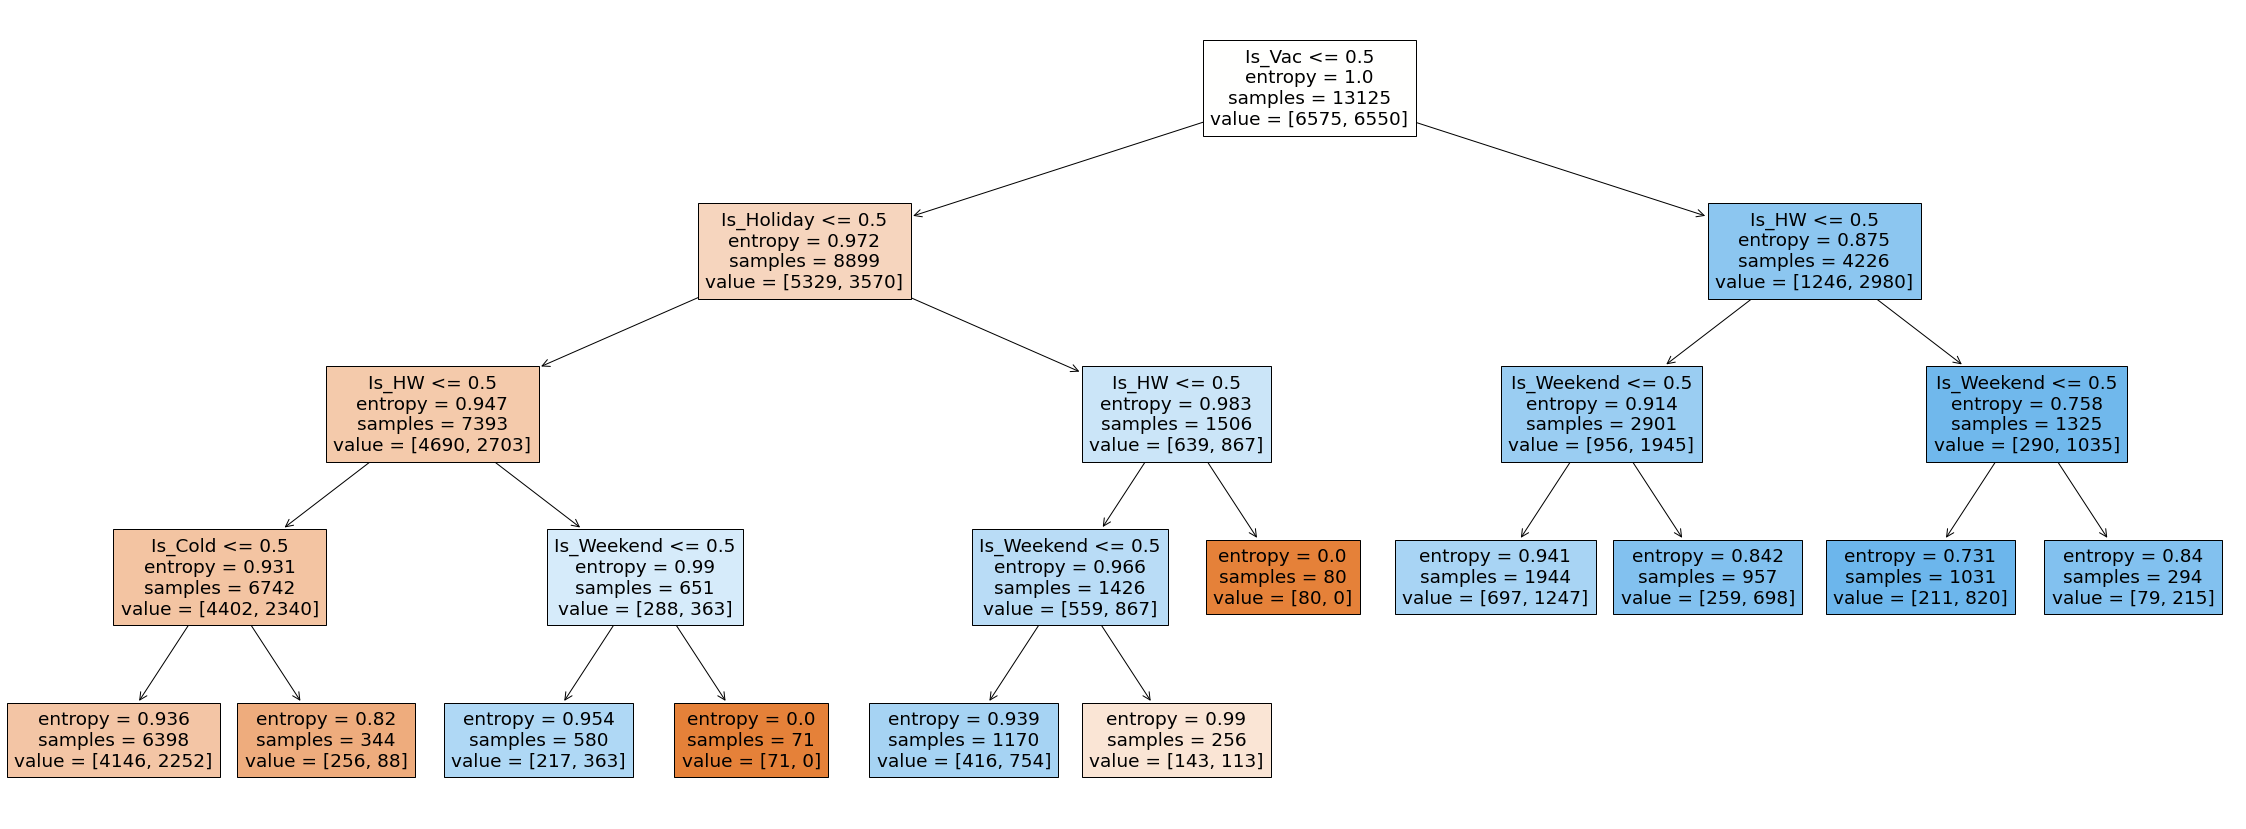

In [39]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show()

In [40]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)
# כאשר הסרנו את פיצר הטמפרטורה, הפיצר של האם חופשה נהפך למשמעותי ביותר

###חיזוי והערכת המודל

In [41]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": without_HM.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,0
15010,1,0
9630,1,1
16150,1,0
13141,1,1


In [42]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# ניתן לראות שחזק יותר בחיזוי של 0

[[2013  787]
 [1062 1763]]
              precision    recall  f1-score   support

           0       0.65      0.72      0.69      2800
           1       0.69      0.62      0.66      2825

    accuracy                           0.67      5625
   macro avg       0.67      0.67      0.67      5625
weighted avg       0.67      0.67      0.67      5625



##יערות רנדומיים

In [43]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') # שלושים עצים

In [44]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [45]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))

# ניתן לראות שחזק יותר בחיזוי של 0

[[2020  780]
 [1062 1763]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      2800
           1       0.69      0.62      0.66      2825

    accuracy                           0.67      5625
   macro avg       0.67      0.67      0.67      5625
weighted avg       0.67      0.67      0.67      5625



###Cross Validation

In [46]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.68125829, 0.69881307, 0.68042032, 0.70558057, 0.69869759,
       0.69821062, 0.69781296, 0.68977797, 0.67764869, 0.68113484])

In [47]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.65813333, 0.67253333, 0.6656    , 0.6816    , 0.68533333,
       0.6704    , 0.67573333, 0.67626667, 0.6688    , 0.65706667])

In [48]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())
# מאחר ופיצר הטמפרטורה הוא המשמעותי ביותר, לאחר הסרתו רמת הדיוק ירדה משמעותית

Mean values
auc: 0.6909354925327623
accuracy:  0.6711466666666667
